# Параметр Тумре

In [1]:
import os
%pylab
%matplotlib inline
%run ./load_notebook.py

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import scipy.interpolate as inter

In [3]:
import functions

importing Jupyter notebook from functions.ipynb
Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [4]:
Distance = 9.3 # Mpc
incl = 62.
cosi = np.cos(incl / 180. * np.pi)
sini = np.sin(incl / 180. * np.pi)

In [5]:
sigma_s = np.load('./data/sigma_s.npy')
Sigma_H2 = np.load('./data/Sigma_H2.npy')
sigma_HI = np.load('./data/sigma_HI.npy')
Sigma_HI = np.load('./data/Sigma_HI.npy')
Sigma_s = np.load('./data/Sigma_s.npy')
sig_R_max = np.load('./data/sig_R_max.npy')
sig_R_min = np.load('./data/sig_R_min.npy')
r_HI = np.load('./data/r_HI.npy')
vel_HI = np.load('./data/vel_HI.npy')
kappa = np.load('./data/kappa.npy')
dist_kpc = np.load('./data/dist_kpc.npy')

In [6]:
velocity_approx = poly1d(polyfit(r_HI, vel_HI, deg=4))

In [7]:
dR =(Distance*1000*2*np.pi)/(360*60*60.)
G = 4.32
Qeff_max = np.zeros(dist_kpc.shape)
Qeff_min = np.zeros(dist_kpc.shape)
bark = np.zeros(dist_kpc.shape)
bark_max = np.zeros(dist_kpc.shape)
Qg = np.zeros(dist_kpc.shape)
Qs_min = np.zeros(dist_kpc.shape)
Qs_max = np.zeros(dist_kpc.shape)
Sigma_g = np.zeros(dist_kpc.shape)

step = 0
errors = 0
for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
        step+=1
        if step % 1000 == 0:
            print(step)
        c = sigma_HI[i][j]/1000.
        Sigma_g[i][j] = 1.36*(Sigma_HI[i][j] + Sigma_H2[i][j])
        kappa = functions.epic_freq(velocity_approx, dist_kpc[i][j], dR)
        Sigma_s_ = Sigma_s[i][j]
        s_R_max = sig_R_max[i][j]
        s_R_min = sig_R_min[i][j]
        Qg[i][j] = kappa * c / (math.pi * G * Sigma_g[i][j])
        Qs_max[i][j] = kappa * s_R_max / (3.36 * G * Sigma_s_)
        Qs_min[i][j] = kappa * s_R_min / (3.36 * G * Sigma_s_)
        
       
        try:
            root_for_max, qeff = functions.FindMaxQeffKinem(rangek=np.arange(0.01, 50., 1.), Qs=Qs_min[i][j], Qg=Qg[i][j], s=c/s_R_min)
        except ValueError:
            errors+=1
            qeff = 0.01
            root_for_max = -1.
        Qeff_min[i][j] = 1./qeff
        bark[i][j] = root_for_max
        
        try:
            root_for_max, qeff = functions.FindMaxQeffKinem(rangek=np.arange(0.01, 50., 1.), Qs=Qs_max[i][j], Qg=Qg[i][j], s=c/s_R_min)
        except ValueError:
            errors+=1
            qeff = 0.01
            root_for_max = -1.
        Qeff_max[i][j] = 1./qeff
        bark_max[i][j] = root_for_max
        
print('Errors:{}'.format(errors))

functions.ipynb:8: RuntimeWarning: invalid value encountered in double_scalars
  ]


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Errors:4704


In [8]:
np.save('./data/Qg.npy', Qg)
np.save('./data/Qs_min.npy', Qs_min)
np.save('./data/Qs_max.npy', Qs_max)
np.save('./data/Qeff_min.npy', Qeff_min)
np.save('./data/Qeff_max.npy', Qeff_max)
np.save('./data/bark.npy',bark)
np.save('./data/bark_max.npy',bark_max)

/home/lera/.local/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)


Text(0.5, 1.0, '$H_{\\alpha}$')

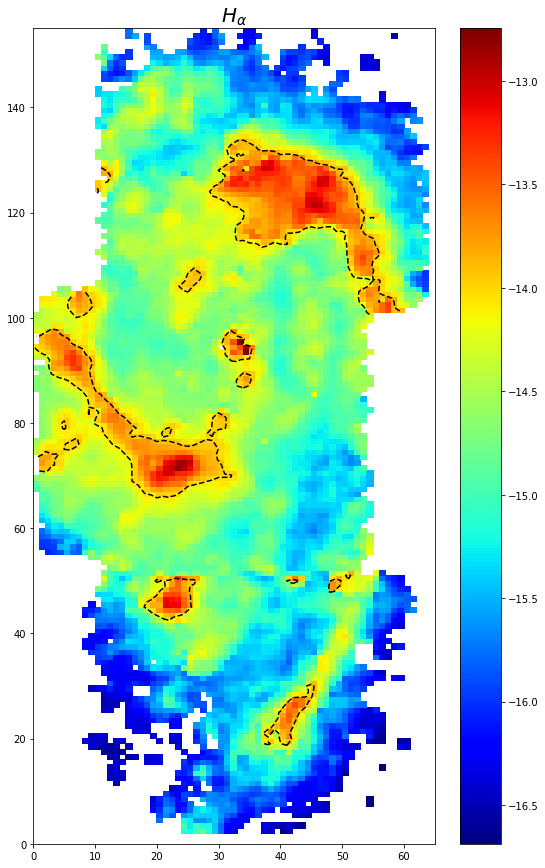

In [9]:
H_alpha = np.load('./data/H_alpha.npy')
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
fig = plt.figure(figsize=[9,15])
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.,-12], aspect='auto', alpha=1, colors='black')
quadmesh = plt.pcolormesh(X, Y, np.log10(H_alpha), cmap='jet')
plt.colorbar()
plt.title(r'$H_{\alpha}$', fontsize=20)

In [10]:
Qg = np.load('./data/Qg.npy')
Qs_min = np.load('./data/Qs_min.npy')
Qeff_min = np.load('./data/Qeff_min.npy')
Qs_max = np.load('./data/Qs_max.npy')
Qeff_max = np.load('./data/Qeff_max.npy')
bark = np.load('./data/bark.npy')
bark_max = np.load('./data/bark_max.npy')

Text(0.5, 1.0, '$\\bar{k}$')

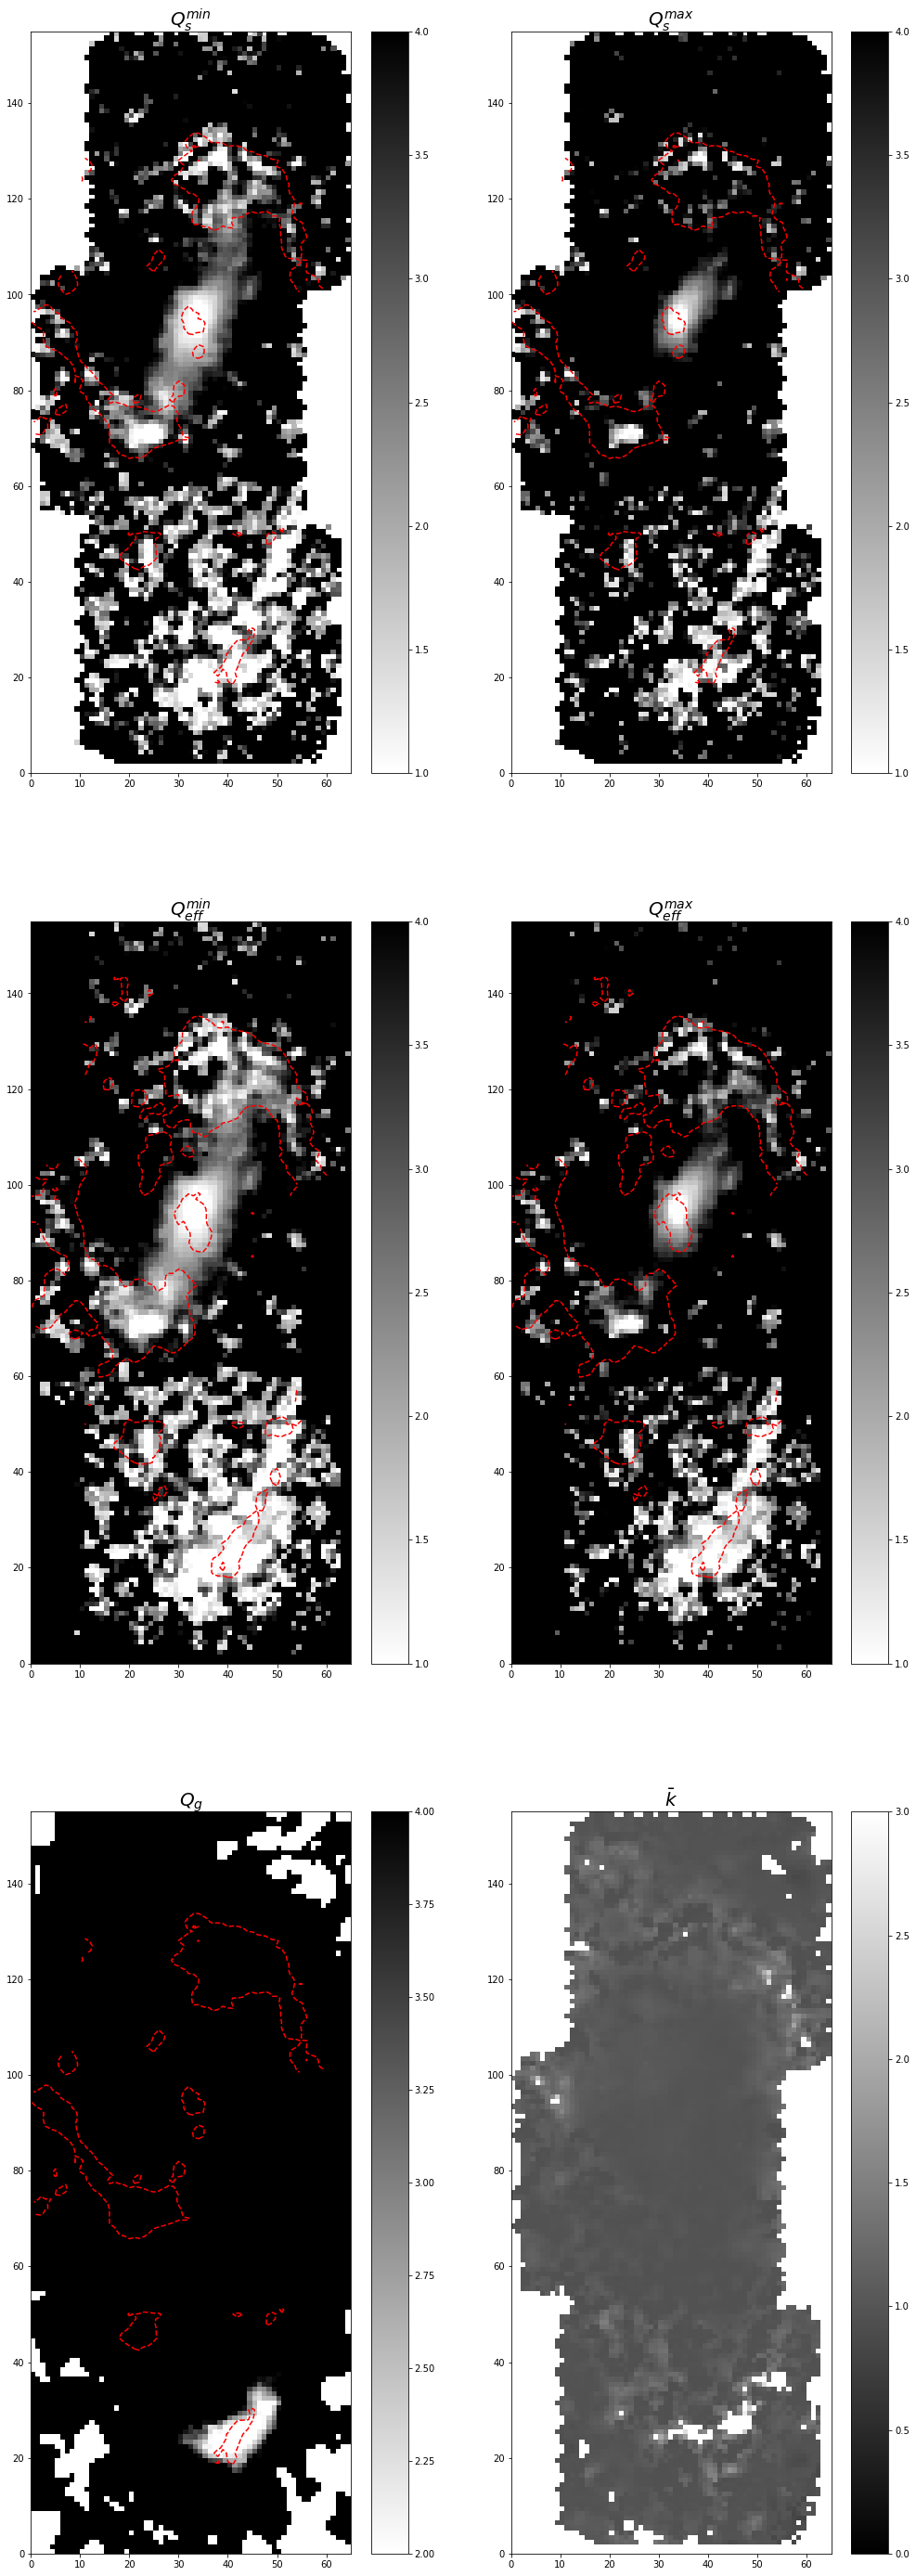

In [11]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[17, 50])
plt.subplot(3,2,1)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qs_min, cmap='gist_yarg')
quadmesh.set_clim(vmin=1., vmax=4.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{s}^{min}$', fontsize=20)

plt.subplot(3,2,2)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qs_max, cmap='gist_yarg')
quadmesh.set_clim(vmin=1., vmax=4.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{s}^{max}$', fontsize=20)

plt.subplot(3,2,3)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.3,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qeff_min, cmap='gist_yarg')
quadmesh.set_clim(vmin=1., vmax=4.)
plt.colorbar()
plt.title(r'$Q_{eff}^{min}$', fontsize=20)

plt.subplot(3,2,4)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.3,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qeff_max, cmap='gist_yarg')
quadmesh.set_clim(vmin=1., vmax=4.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{eff}^{max}$', fontsize=20)

plt.subplot(3,2,5)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qg, cmap='gist_yarg')
quadmesh.set_clim(vmin=2., vmax=4.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{g}$', fontsize=20)

plt.subplot(3,2,6)
quadmesh = plt.pcolormesh(X, Y, bark, cmap='gray')
quadmesh.set_clim(vmin=0., vmax=3.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$\bar{k}$', fontsize=20)

Text(0.5, 1.0, '$Q_{eff}^{max}$')

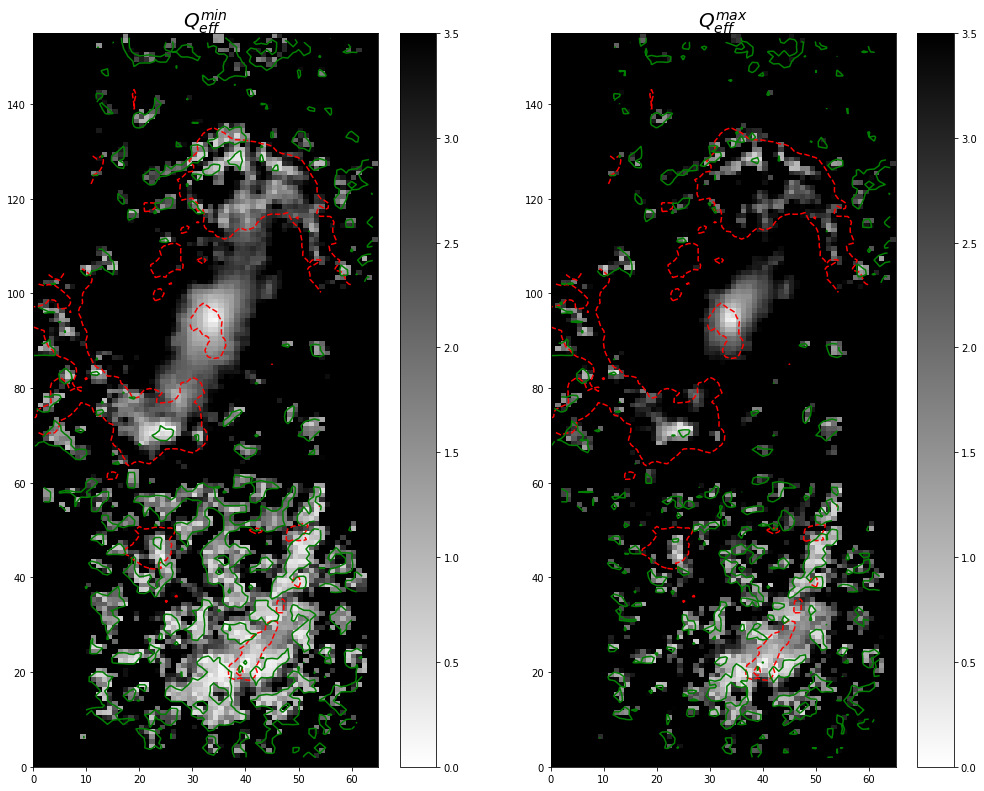

In [31]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[17, 13.5])
plt.subplot(1,2,1)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.2,-12], aspect='auto', alpha=1, colors='red')
CS = plt.contour(X, Y, sig_R_min, levels=[0,25], aspect='auto', alpha=1, colors='green')
quadmesh = plt.pcolormesh(X, Y, Qeff_min, cmap='gist_yarg')
quadmesh.set_clim(vmin=0., vmax=3.5)
plt.colorbar()
plt.title(r'$Q_{eff}^{min}$', fontsize=20)

plt.subplot(1,2,2)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.2,-12], aspect='auto', alpha=1, colors='red')
CS = plt.contour(X, Y, sig_R_max, levels=[0,32], aspect='auto', alpha=1, colors='green')
quadmesh = plt.pcolormesh(X, Y, Qeff_max, cmap='gist_yarg')
quadmesh.set_clim(vmin=0., vmax=3.5)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{eff}^{max}$', fontsize=20)

Теперь в качестве порога для звездообразования возьмём критерий: область нустойчива при $\Sigma_{HI}>5 
M_{\odot}/kpc^2 $

Text(0.5, 1.0, '$Q_{eff}^{max}$')

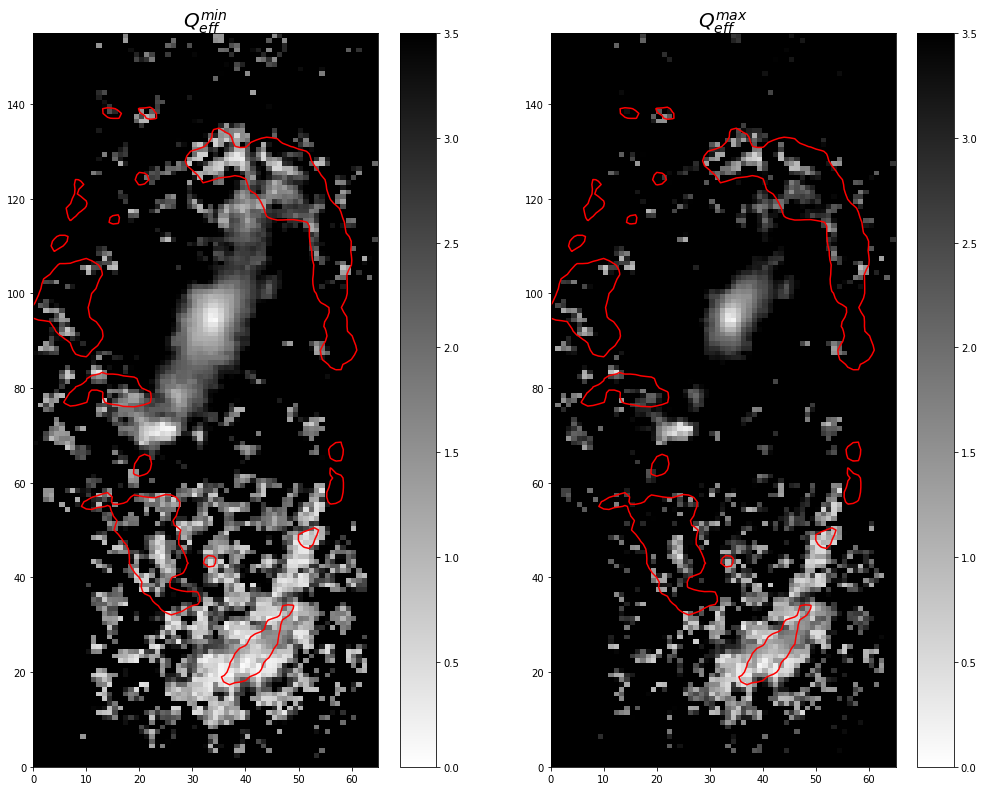

In [23]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[17, 13.5])
plt.subplot(1,2,1)
CS = plt.contour(X, Y, Sigma_HI, levels=[5,], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qeff_min, cmap='gist_yarg')
quadmesh.set_clim(vmin=0., vmax=3.5)
plt.colorbar()
plt.title(r'$Q_{eff}^{min}$', fontsize=20)

plt.subplot(1,2,2)
CS = plt.contour(X, Y, Sigma_HI, levels=[5,], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qeff_max, cmap='gist_yarg')
quadmesh.set_clim(vmin=0., vmax=3.5)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{eff}^{max}$', fontsize=20)

## Нижний квадрат

In [16]:
number = [[25,35], [15,47], [32,15], [54,45], [20,34], [25,60], [9,25], [30,50], [37,38], [45,35], [24,43], [150,46], [147, 55]]
Qeff_max_ = []
Qeff_min_ = []
k_max = []
k_min = []
for i,j in number:
    c = sigma_HI[i][j]/1000.
    Sigma_gas = 1.36*(Sigma_HI[i][j] + Sigma_H2[i][j])
    epic = functions.epic_freq(velocity_approx, dist_kpc[i][j], dR)
    Qeff_max_.append(Qeff_max[i][j])
    k_max.append(bark_max[i][j])
    Qeff_min_.append(Qeff_min[i][j])
    k_min.append(bark[i][j])
    
    print('Координаты пикселя ', i,j)
    print('𝜅 = ', epic)
    print('𝜎𝑚𝑎𝑥 = ', sig_R_max[i][j])
    print('𝜎𝑚𝑖𝑛 = ', sig_R_min[i][j])
    print('Σ𝑔𝑎𝑠 = ', Sigma_gas)
    print('Σ𝑠𝑡𝑎𝑟 = ', Sigma_s[i][j])
    print('𝜎𝐻𝐼 = ', c)
    print('k_max = ', bark_max[i][j])
    print('Q_max = ', Qeff_max[i][j])
    print('k_min = ', bark[i][j])
    print('Q_min = ', Qeff_min[i][j])
    print()

Координаты пикселя  25 35
𝜅 =  58.19922168183904
𝜎𝑚𝑎𝑥 =  190.57221376774555
𝜎𝑚𝑖𝑛 =  101.0724176586633
Σ𝑔𝑎𝑠 =  27.001914825439457
Σ𝑠𝑡𝑎𝑟 =  102.48318
𝜎𝐻𝐼 =  21.443919921875
k_max =  3.8919698040628674
Q_max =  2.856089094937121
k_min =  2.6129657917331666
Q_min =  2.4245507026460693

Координаты пикселя  15 47
𝜅 =  74.79700351545225
𝜎𝑚𝑎𝑥 =  11.746654450381419
𝜎𝑚𝑖𝑛 =  6.762301791831318
Σ𝑔𝑎𝑠 =  7.312603073120118
Σ𝑠𝑡𝑎𝑟 =  51.275955
𝜎𝐻𝐼 =  25.85016796875
k_max =  0.9551682037353074
Q_max =  1.0735682414713488
k_min =  0.9630509099208571
Q_min =  0.6254558731354624

Координаты пикселя  32 15
𝜅 =  83.37563332738009
𝜎𝑚𝑎𝑥 =  47.21028499187702
𝜎𝑚𝑖𝑛 =  23.2433130645748
Σ𝑔𝑎𝑠 =  2.1114340591430665
Σ𝑠𝑡𝑎𝑟 =  58.75751
𝜎𝐻𝐼 =  34.88609765625
k_max =  0.9632005921516591
Q_max =  4.152443879827445
k_min =  0.9684591924102621
Q_min =  2.08487368792496

Координаты пикселя  54 45
𝜅 =  232.83804800954215
𝜎𝑚𝑎𝑥 =  41.06521181007348
𝜎𝑚𝑖𝑛 =  25.16794352579009
Σ𝑔𝑎𝑠 =  14.421556854248047
Σ𝑠𝑡𝑎𝑟 =  148.67278
𝜎𝐻𝐼 =  33.

Text(0.5, 1.0, '$Q_{eff}^{min}$')

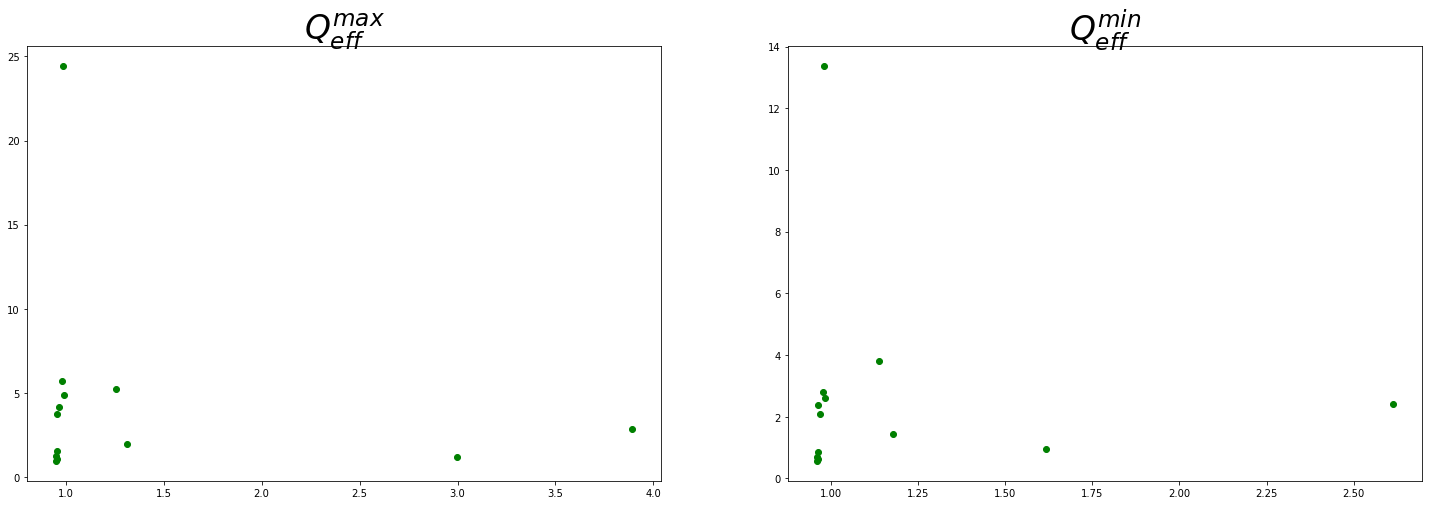

In [20]:
fig = plt.figure(figsize=[25, 8])

plt.subplot(1,2,1)
plt.plot(k_max,Qeff_max_,'o', color='green')
plt.title(r'$Q_{eff}^{max}$', fontsize=33)

          
plt.subplot(1,2,2)
plt.plot(k_min,Qeff_min_,'o', color='green')
plt.title(r'$Q_{eff}^{min}$', fontsize=33)
          

In [19]:
dR =(Distance*1000*2*np.pi)/(360*60*60.)
G = 4.32
Qeff_max_ = []
Qeff_min_ = []
k_max = []
k_min = []
for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
        if (4.3 < dist_kpc[i][j] < 4.35):
            c = sigma_HI[i][j]/1000.
            Sigma_gas = 1.36*(Sigma_HI[i][j] + Sigma_H2[i][j])
            epic = functions.epic_freq(velocity_approx, dist_kpc[i][j], dR)
            Qeff_max_.append(Qeff_max[i][j])
            k_max.append(bark_max[i][j])
            Qeff_min_.append(Qeff_min[i][j])
            k_min.append(bark[i][j])
    
            print('Координаты пикселя ', i,j)
            print('𝜅 = ', epic)
            print('𝜎𝑚𝑎𝑥 = ', sig_R_max[i][j])
            print('𝜎𝑚𝑖𝑛 = ', sig_R_min[i][j])
            print('Σ𝑔𝑎𝑠 = ', Sigma_gas)
            print('Σ𝑠𝑡𝑎𝑟 = ', Sigma_s[i][j])
            print('𝜎𝐻𝐼 = ', c)
            print('k_max = ', bark_max[i][j])
            print('Q_max = ', Qeff_max[i][j])
            print('k_min = ', bark[i][j])
            print('Q_min = ', Qeff_min[i][j])
            print()

Координаты пикселя  55 28
𝜅 =  248.50324267476947
𝜎𝑚𝑎𝑥 =  103.43332247471137
𝜎𝑚𝑖𝑛 =  51.936004627975144
Σ𝑔𝑎𝑠 =  17.235093688964845
Σ𝑠𝑡𝑎𝑟 =  140.01817
𝜎𝐻𝐼 =  44.5688671875
k_max =  1.0018182522168417
Q_max =  9.491234470497384
k_min =  0.9888949290935961
Q_min =  5.286897847424976

Координаты пикселя  55 29
𝜅 =  248.95908615781747
𝜎𝑚𝑎𝑥 =  149.03610288753237
𝜎𝑚𝑖𝑛 =  75.37268769094646
Σ𝑔𝑎𝑠 =  16.571857376098635
Σ𝑠𝑡𝑎𝑟 =  147.9576
𝜎𝐻𝐼 =  43.88449609375
k_max =  1.0766179654846586
Q_max =  12.50072747003967
k_min =  1.0275314125205524
Q_min =  7.129959566178727

Координаты пикселя  55 30
𝜅 =  249.28760067907376
𝜎𝑚𝑎𝑥 =  126.09511817596395
𝜎𝑚𝑖𝑛 =  64.29156850025743
Σ𝑔𝑎𝑠 =  16.484747161865236
Σ𝑠𝑡𝑎𝑟 =  153.40704
𝜎𝐻𝐼 =  43.52794921875
k_max =  1.0404241213891319
Q_max =  10.534973404520969
k_min =  1.0094679996935687
Q_min =  5.966491067908187

Координаты пикселя  55 31
𝜅 =  249.48870870009355
𝜎𝑚𝑎𝑥 =  49.62892294250701
𝜎𝑚𝑖𝑛 =  25.533823508807114
Σ𝑔𝑎𝑠 =  15.962281723022462
Σ𝑠𝑡𝑎𝑟 =  150.117
𝜎𝐻𝐼 =  

Координаты пикселя  142 4
𝜅 =  249.23572076541527
𝜎𝑚𝑎𝑥 =  nan
𝜎𝑚𝑖𝑛 =  nan
Σ𝑔𝑎𝑠 =  5.3804545402526855
Σ𝑠𝑡𝑎𝑟 =  57.365135
𝜎𝐻𝐼 =  20.223322265625
k_max =  -1.0
Q_max =  100.0
k_min =  -1.0
Q_min =  100.0

Координаты пикселя  142 60
𝜅 =  249.79144760007995
𝜎𝑚𝑎𝑥 =  168.1402157557962
𝜎𝑚𝑖𝑛 =  99.11849312748353
Σ𝑔𝑎𝑠 =  -2.129009828567505
Σ𝑠𝑡𝑎𝑟 =  46.10585
𝜎𝐻𝐼 =  27.022673828125
k_max =  0.8980172362878184
Q_max =  66.73674062520381
k_min =  0.9278580068932526
Q_min =  37.29160345512383

Координаты пикселя  143 6
𝜅 =  251.10476422239225
𝜎𝑚𝑎𝑥 =  nan
𝜎𝑚𝑖𝑛 =  nan
Σ𝑔𝑎𝑠 =  8.476481552124024
Σ𝑠𝑡𝑎𝑟 =  61.61138
𝜎𝐻𝐼 =  18.41686328125
k_max =  -1.0
Q_max =  100.0
k_min =  -1.0
Q_min =  100.0

Координаты пикселя  143 59
𝜅 =  248.25254008804137
𝜎𝑚𝑎𝑥 =  260.61551380738683
𝜎𝑚𝑖𝑛 =  150.59500968649928
Σ𝑔𝑎𝑠 =  -1.2717434024810792
Σ𝑠𝑡𝑎𝑟 =  48.287304
𝜎𝐻𝐼 =  30.03069140625
k_max =  0.9244743282814284
Q_max =  93.15386320031143
k_min =  0.9446048073673168
Q_min =  52.11925908406498

Координаты пикселя  144 7
𝜅 =  2

# Азимутальное усреднение

In [26]:
def azimuthal_average(Q, step=None, vmax=None, maxval=None, vmin=0.5):
    az_av = []
    az_dev = []
    for dbin in np.arange(vmin,vmax,step):
        mask = (dist_kpc >= dbin) & (dist_kpc <= dbin + step)
        anulli = Q[mask]
        mask = (anulli < maxval) & (anulli > 0.) 
        anulli = anulli[mask]
        az_av.append(anulli.sum()/mask.sum())
        az_dev.append(np.std(anulli))
    return az_av, az_dev

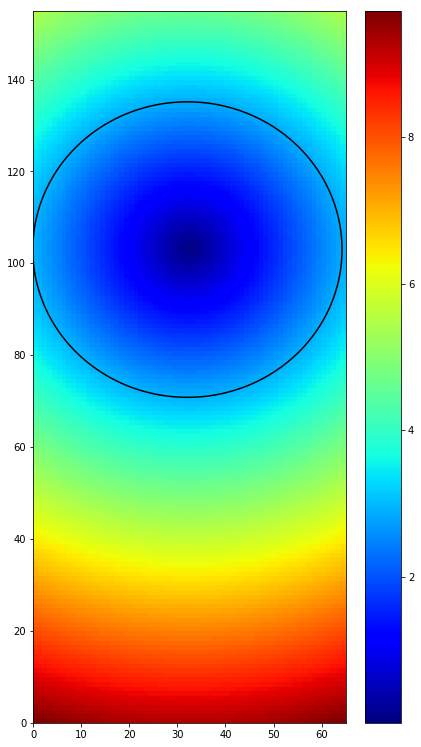

In [28]:
plt.figure(figsize=[7.,13.1])
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
CS = plt.contour(X, Y, dist_kpc, levels=[0.,2.9], aspect='auto', alpha=1, colors='black')
quadmesh = plt.pcolormesh(X, Y, dist_kpc, cmap='jet')
plt.colorbar()
#3.25 -масимальный радиус усреднения на кругу

In [24]:
Qeff_min = np.load('./data/Qeff_min.npy')
Qeff_max = np.load('./data/Qeff_max.npy')
Qg = np.load('./data/Qg.npy')
shear_method = np.load('./data/shear_method.npy')

In [27]:
plt.figure(figsize=[14,10])
for ind, Q in enumerate([Qeff_min, Qeff_max, Qg, shear_method]):
    label = ['Qeff_min', 'Qeff_max', 'Qg','shear_method'][ind]
    color = ['r', 'g', 'm','blue'][ind]
    az_av, az_dev = azimuthal_average(Q, step=0.5, vmax=10.)
    plt.plot(np.array(np.arange(0,10.,0.5)), az_av, ':', label=label, color=color)

plt.grid()
plt.legend()
plt.axvline(x=11., alpha=0.3)
plt.ylim(0, 40.5);

TypeError: unorderable types: float() < NoneType()

<Figure size 1008x720 with 0 Axes>

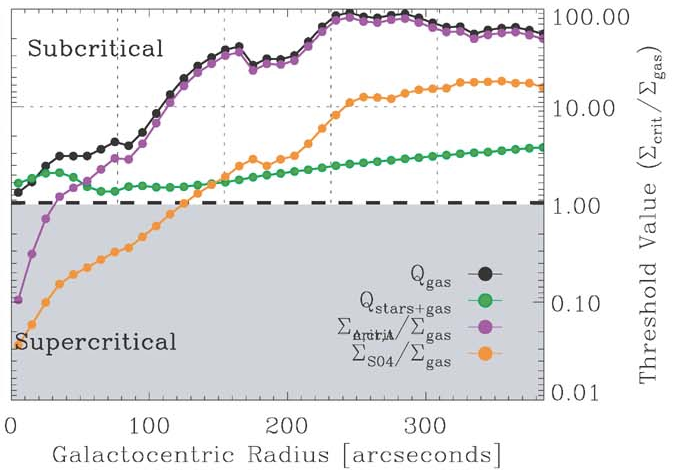

In [75]:
from IPython.display import Image
Image('./images/instability.png')

In [55]:
sigma_s = np.load('./data/sigma_s.npy')
Sigma_H2 = np.load('./data/Sigma_H2.npy')
sigma_HI = np.load('./data/sigma_HI.npy')
Sigma_HI = np.load('./data/Sigma_HI.npy')
Sigma_s = np.load('./data/Sigma_s.npy')
sig_R_max = np.load('./data/sig_R_max.npy')
sig_R_min = np.load('./data/sig_R_min.npy')
r_HI = np.load('./data/r_HI.npy')
vel_HI = np.load('./data/vel_HI.npy')
kappa = np.load('./data/kappa.npy')
dist_kpc = np.load('./data/dist_kpc.npy')

In [50]:
velocity_approx = poly1d(polyfit(r_HI, vel_HI, deg=4))

In [51]:
Sigma_H2_az = azimuthal_average(Sigma_H2, step=0.5, vmax=11., maxval = 140.)[0]
sigma_HI_az = azimuthal_average(sigma_HI/1000., step=0.5, vmax=11., maxval = 100.)[0]
Sigma_HI_az = azimuthal_average(Sigma_HI, step=0.5, vmax=11., maxval = 7.)[0]
Sigma_s_az = azimuthal_average(Sigma_s, step=0.5, vmax=11., maxval = 4000.)[0]
sig_R_max_az = azimuthal_average(sig_R_max, step=0.5, vmax=11., maxval = 300.)[0]
sig_R_min_az = azimuthal_average(sig_R_min, step=0.5, vmax=11., maxval = 300.)[0]
dist_az = np.array(np.arange(0.5,11.,0.5))

/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [52]:
dR =(Distance*1000*2*np.pi)/(360*60*60.)
G = 4.32

Qeff_max_az = np.zeros(dist_az.shape)
Qeff_min_az = np.zeros(dist_az.shape)
Qg_az = np.zeros(dist_az.shape)
Qs_max_az = np.zeros(dist_az.shape)
Qs_min_az = np.zeros(dist_az.shape)
error = 0
step = 0
for i, ddd in enumerate(np.arange(0.5, 11., 0.5)):
    step+=1
    c = sigma_HI_az[i]
    Sigma_g = 1.36*(Sigma_HI_az[i]+ Sigma_H2_az[i])
    kappa = functions.epic_freq(velocity_approx, ddd, dR)
    Sigma_s = Sigma_s_az[i]
    s_R_max = sig_R_max_az[i]
    s_R_min = sig_R_min_az[i]
    Qg_az[i] = kappa * c / (math.pi * G * Sigma_g)
    Qs_max_az[i] = kappa * s_R_max / (3.36 * G * Sigma_s)
    Qs_min_az[i] = kappa * s_R_min / (3.36 * G * Sigma_s)
        
    try:   
        root, qeff = functions.FindMaxQeffKinem(rangek=np.arange(0.01, 50., 1.), Qs=Qs_min_az[i], Qg=Qg_az[i], s=c/s_R_min)
    except:
        error+=1
        qeff = 0.01
    Qeff_min_az[i] = 1./qeff
    
    try: 
        root,qeff = functions.FindMaxQeffKinem(rangek=np.arange(0.01, 50., 1.), Qs=Qs_max_az[i], Qg=Qg_az[i], s=c/s_R_min)
    except:
        error+=1
        qeff = 0.01
    Qeff_max_az[i] = 1./qeff
print(error)               

6


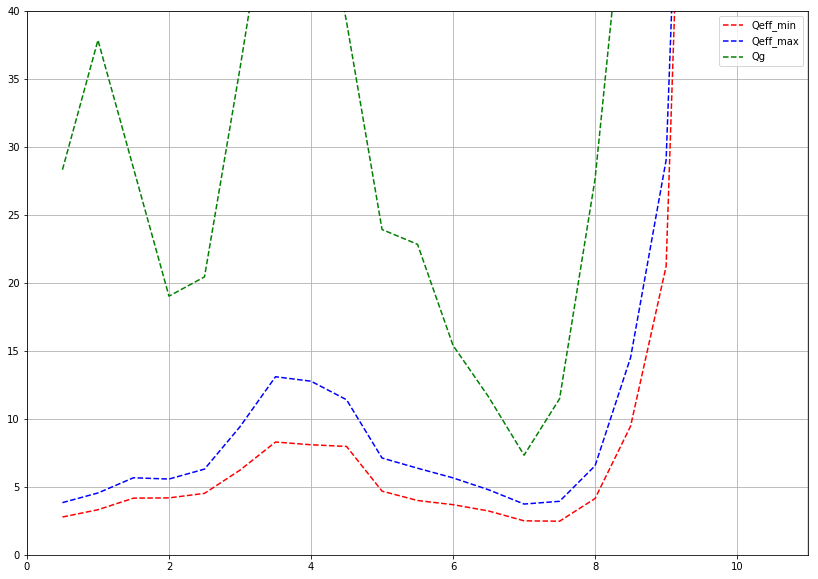

In [53]:
plt.figure(figsize=[14,10])
plt.plot(np.array(np.arange(0.5,11.,0.5)),Qeff_min_az, '--', label='Qeff_min', color='red')


plt.plot(np.array(np.arange(0.5,11.,0.5)),Qeff_max_az, '--', label='Qeff_max', color='blue')

plt.plot(np.array(np.arange(0.5,11.,0.5)),Qg_az, '--', label='Qg', color='green')
 


plt.grid()
plt.legend()
plt.axvline(x=11., alpha=0.3)
plt.ylim(0, 40.);

Возьмём данные Лероя

In [34]:
dist_Leroy_eff_arcsec = [5.78, 15.60 ,25.43 ,35.26 ,45.66 ,55.49 ,65.31 ,75.72 ,85.54 ,95.37 ,105.20,115.60, 125.43, 
135.26,145.08,155.49,164.73,175.14,184.97,194.79,204.62,215.02,224.85,234.68,244.50,254.91,264.73,274.56,284.39,  294.79, 
304.62,315.02,324.85,334.68,343.93,354.91,364.73,374.56,384.39]
Qeff_Leroy  =[ 2.86, 3.23,  3.82, 3.83, 3.38, 2.48, 2.04, 2.11, 2.56, 2.56, 2.48, 2.49, 2.48, 2.63,2.86, 2.93, 3.23,
 3.38,  3.60, 3.75,3.97,4.04,4.27, 4.49, 4.64, 4.79, 4.86, 4.94, 5.16, 5.31, 5.31, 5.53, 5.54, 5.76, 5.83, 5.91,
 5.98, 6.13, 6.13]
Leroy_gas = [5.263157894736844, 1.6881578947368432,
14.619883040935676 ,2.595175438596492,
24.56140350877194, 4.177631578947372,
34.502923976608194, 5.085087719298249,
45.02923976608188, 5.017982456140352,
54.38596491228071, 5.100000000000003,
64.91228070175441, 5.782894736842108,
75.43859649122808, 6.390789473684212,
85.38011695906434, 6.098245614035088,
95.32163742690062, 7.380701754385967,
105.26315789473685, 9.113157894736844,
115.11627906976743,  21.63793103448276,
125.0,  37.155172413793096,
134.88372093023256,  48.79310344827586,
144.7674418604651,  58.103448275862064,
154.65116279069767,  65.08620689655172,
165.11627906976744,  68.9655172413793,
175.0,  50.3448275862069,
185.46511627906975,  56.55172413793103,
195.34883720930233,  55.775862068965516,
204.65116279069767,  59.6551724137931,
215.11627906976744,  72.06896551724138,
225.0,  87.58620689655173,
234.88372093023258,  97.67241379310344,
244.7674418604651,  100.77586206896552,
255.2325581395349,  96.89655172413794,
265.1162790697674,  96.12068965517241,
275.0,  98.44827586206897,
284.8837209302326,  100.0,
294.7674418604651,  96.12068965517241,
305.2325581395349,  89.91379310344828,
315.1162790697675,  86.8103448275862,
325.0,  86.8103448275862,
335.4651162790698,  79.82758620689656,
345.3488372093023,  83.70689655172414,
355.2325581395349,  85.25862068965517,
365.1162790697674,  86.03448275862068,
375.0,  83.70689655172414,
384.8837209302325,  79.82758620689656]

In [35]:
dist_Leroy_eff = [r * np.pi / (180 *3600) * Distance * 10**3 for r in dist_Leroy_eff_arcsec]

Leroy_gas[0::2] = [r * np.pi / (180 *3600) * Distance * 10**3 for r in Leroy_gas[0::2]]

(0, 12)

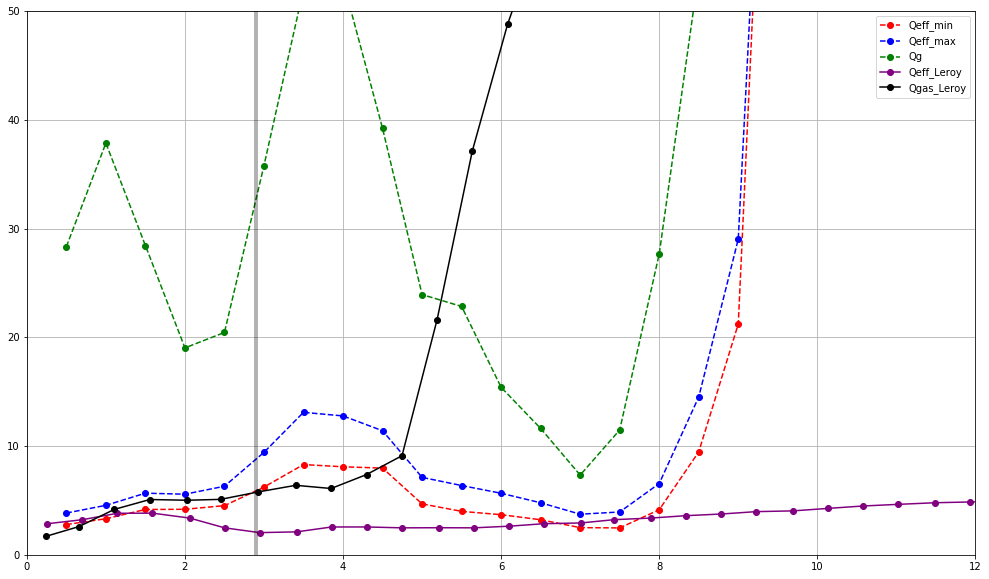

In [37]:
plt.figure(figsize=[17,10])
plt.plot(np.array(np.arange(0.5,11.,0.5)),Qeff_min_az, 'o--', label='Qeff_min', color='red')


plt.plot(np.array(np.arange(0.5,11.,0.5)),Qeff_max_az, 'o--', label='Qeff_max', color='blue')

plt.plot(np.array(np.arange(0.5,11.,0.5)),Qg_az, 'o--', label='Qg', color='green')
plt.plot(dist_Leroy_eff,Qeff_Leroy, 'o-', label='Qeff_Leroy', color='purple') 
plt.plot(Leroy_gas[0::2],Leroy_gas[1::2], 'o-', label='Qgas_Leroy', color='black')


plt.grid()
plt.legend()
plt.axvline(x=2.9, alpha=0.3, color='black', lw=4) # Граница усреднения по кругу 
plt.ylim(0, 50.)
plt.xlim(0,12)

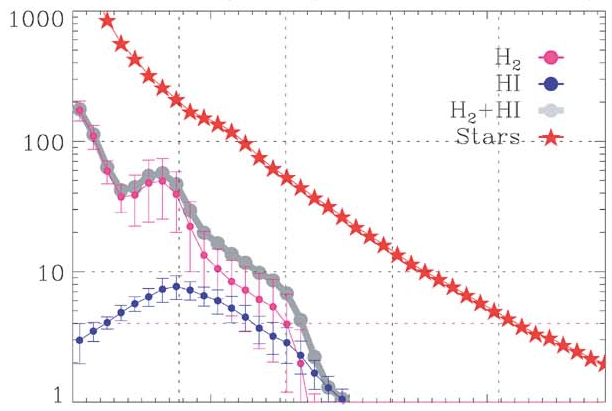

In [38]:
from IPython.display import Image
Image('./images/density.png')

In [58]:
Sigma_s_Leroy = [23.598233349907858,  846.0076724483293,
33.63654976746908,  567.7928824435597,
43.64561701131943,  433.3826375784002,
53.65760917254089,  326.56262656603906,
63.64912691216473,  269.2573689496928,
73.65234432127293,  210.87366509536247,
83.64971189563896,  169.4533969415193,
94.14139050571823,  154.8617398091692,
104.11828365848665,  136.16898877360853,
114.09517681125509,  119.73256613593385,
124.2105263157895,  96.21443268927803,
134.21052631578948,  75.35203264966117,
145.26315789473688,  60.55122100314917,
154.73684210526318,  52.56181956608316,
165.26315789473688,  43.899351080815435,
175.26315789473688,  37.13918782987277,
184.73684210526318,  31.42003785257203,
194.73684210526318,  26.24184786693744,
205.26315789473688,  21.63692455358421,
215.26315789473688,  18.782051055441148,
225.26315789473688,  15.486173980916927,
234.73684210526318,  13.793192726625698,
245.26315789473688,  11.372761243504481,
255.56437389770724,  9.623506263980897,
266.17577895355674,  8.4679401098553,
275.7289829512052,  7.451131400254735,
285.81422692533806,  6.473082037010402,
295.896531452087,  5.695810810737687,
306.51381540270427,  4.885273571519392,
316.59318048206933,  4.354004653656649,
326.1552028218695,  3.6869450645195774,
336.23750734861846,  3.24422607917163,
346.305114638448,  3.043219887107722,
356.91358024691357,  2.7122725793320295,
366.4609053497942,  2.448436746822227,
376.54320987654324,  2.1544346900318843,
386.6166960611405,  1.969901198590982
]

In [59]:
Sigma_H2_Leroy = [5.26315789473685,  171.53108722672815,
15.26315789473685,  109.20774884568348,
24.867724867724874,  58.99846085308591,
34.920634920634924,  37.65630843286818,
44.97354497354496,  38.09209011334099,
55.026455026455025,  47.28471246851614,
65.60846560846561,  49.06813253929407,
75.66137566137567,  38.92611260972658,
85.18518518518519,  22.144582139419853,
95.23809523809524,  13.428958386514637,
105.82010582010582,  10.517169735529139,
115.26315789473682,  8.360306936514649,
125.26315789473685,  7.3564225445964135,
135.78947368421052,  6.150195042752213,
145.26315789473685,  5.481367101558418,
155.78947368421055,  4.032325252111344,
165.26315789473682,  2.020949938191079
]

In [60]:
Sigma_HI_Leroy = [4.7368421052631575,  2.9645519440048984,
14.736842105263158,  3.451995138649937,
25.263157894736857,  4.0710609299344,
34.73684210526316,  4.801793824856349,
45.26315789473686,  5.590947061552852,
54.21052631578949,  6.346639928259899,
65.26315789473685,  7.2025350455855115,
75.26315789473685,  7.570979091031694,
84.73684210526318,  7.184615133964143,
84.73684210526318,  7.184615133964143,
94.73684210526318,  6.395109030978997,
104.73684210526318,  5.839874427780476,
115.26315789473685,  5.131722431574832,
124.73684210526318,  4.452723534191639,
134.73684210526315,  3.5778796745936434,
144.73684210526318,  3.1042669727473213,
154.73684210526318,  2.763143937681283,
164.73684210526315,  2.248842624731288,
174.73684210526318,  1.6312278211817017,
185.26315789473685,  1.2613009227352183,
194.73684210526315,  1.0135564768245204
]

In [62]:
Sigma_s_Leroy[0::2] = [r * np.pi / (180 *3600) * Distance * 10**3 for r in Sigma_s_Leroy[0::2]]
Sigma_HI_Leroy[0::2] = [r * np.pi / (180 *3600) * Distance * 10**3 for r in Sigma_HI_Leroy[0::2]]
Sigma_H2_Leroy[0::2] = [r * np.pi / (180 *3600) * Distance * 10**3 for r in Sigma_H2_Leroy[0::2]]


In [56]:
Sigma_H2_az, Sigma_H2_az_dev = azimuthal_average(1.36*Sigma_H2, step=0.5, vmax=11., maxval = 140.)
Sigma_HI_az, Sigma_HI_az_dev = azimuthal_average(1.36*Sigma_HI, step=0.5, vmax=11., maxval = 7.)
Sigma_s_az, Sigma_s_az_dev = azimuthal_average(Sigma_s, step=0.5, vmax=11., maxval = 4000.)

/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


(0.0, 12.0)

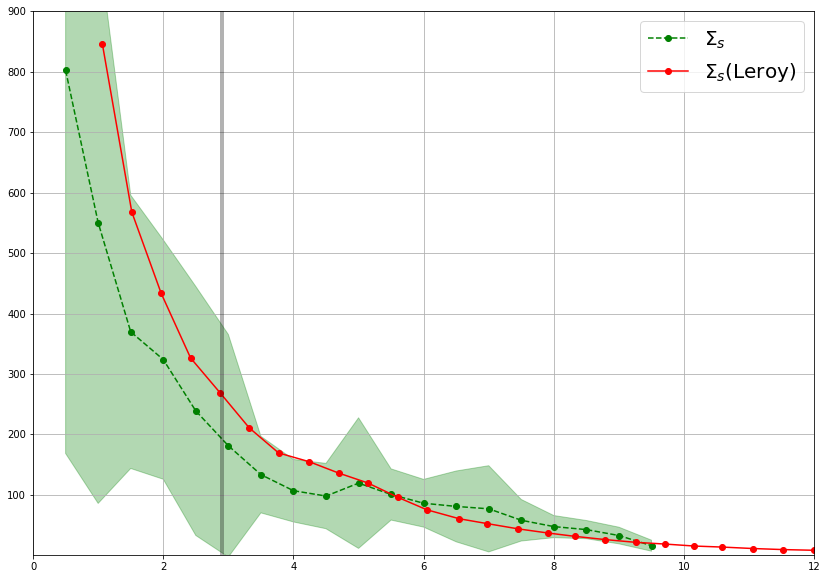

In [63]:
plt.figure(figsize=[14,10])
plt.plot(np.array(np.arange(0.5,11.,0.5)),Sigma_s_az, 'o--', label=r'$\Sigma_{s}$', color='green')
plt.fill_between(np.array(np.arange(0.5,11.,0.5)), 
                     np.array(Sigma_s_az) - np.array(Sigma_s_az_dev), 
                     np.array(Sigma_s_az) + np.array(Sigma_s_az_dev), alpha=0.3, color='green')
plt.plot(Sigma_s_Leroy[0::2],Sigma_s_Leroy[1::2], 'o-', label=r'$\Sigma_s$(Leroy)', color='red') 

plt.grid()
plt.legend(fontsize=20)
plt.axvline(x=2.9, alpha=0.3, color='black', lw=4) # Граница усреднения по кругу 
plt.ylim(1., 900.)
plt.xlim(0., 12.)

(0, 10.0)

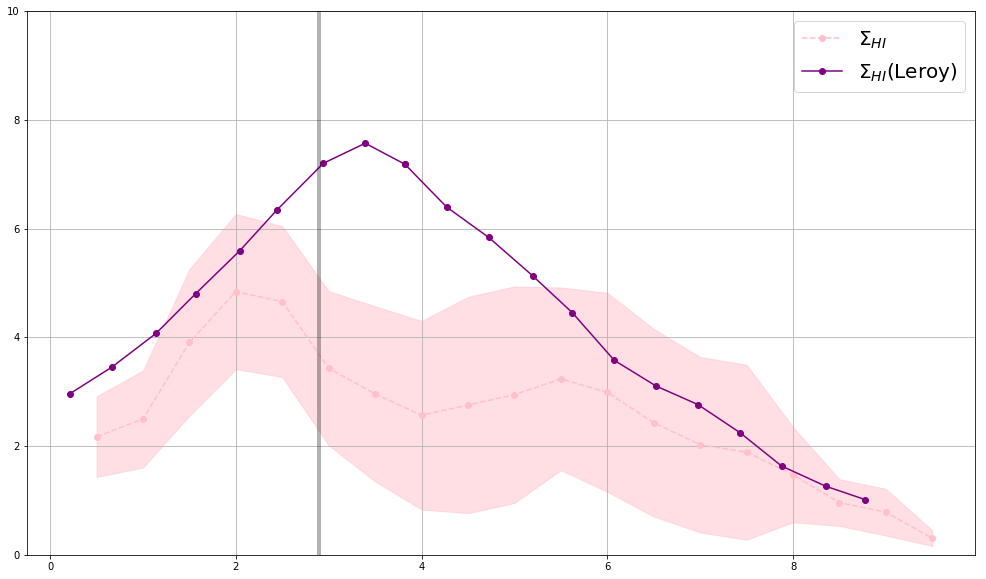

In [66]:
plt.figure(figsize=[17,10])
#Sigma_HI_az1=[Sigma_HI_az[i]*1.36 for i in range(len(Sigma_HI_az))]
plt.plot(np.array(np.arange(0.5,11.,0.5)),Sigma_HI_az, 'o--', label=r'$\Sigma_{HI}$', color='pink')
plt.fill_between(np.array(np.arange(0.5,11.,0.5)), 
                     np.array(Sigma_HI_az) - np.array(Sigma_HI_az_dev), 
                     np.array(Sigma_HI_az) + np.array(Sigma_HI_az_dev), alpha=0.5, color='pink')
plt.plot(Sigma_HI_Leroy[0::2],Sigma_HI_Leroy[1::2], 'o-', label=r'$\Sigma_{HI}$(Leroy)', color='purple')

plt.grid()
plt.legend(fontsize=20)
plt.axvline(x=2.9, alpha=0.3, color='black', lw=4)
plt.ylim(0, 10.)

(0, 140.0)

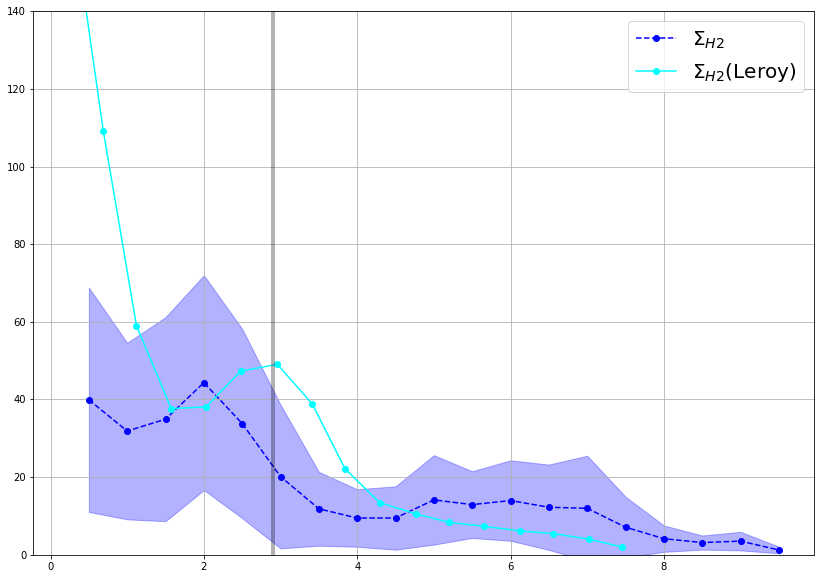

In [67]:
plt.figure(figsize=[14,10])

#Sigma_H2_az1=[Sigma_H2_az[i]*1.36 for i in range(len(Sigma_H2_az))]
plt.plot(np.array(np.arange(0.5,11.,0.5)),Sigma_H2_az, 'o--', label=r'$\Sigma_{H2}$', color='blue')
plt.fill_between(np.array(np.arange(0.5,11.,0.5)), 
                     np.array(Sigma_H2_az) - np.array(Sigma_H2_az_dev), 
                     np.array(Sigma_H2_az) + np.array(Sigma_H2_az_dev), alpha=0.3, color='blue')
plt.plot(Sigma_H2_Leroy[0::2],Sigma_H2_Leroy[1::2], 'o-', label=r'$\Sigma_{H2}$(Leroy)', color='aqua')


plt.grid()
plt.legend(fontsize=20)
plt.axvline(x=2.9, alpha=0.3, color='black', lw=4)
plt.ylim(0, 140.)